<a href="https://colab.research.google.com/github/SahilBhutani09/Sahil-Assignments/blob/test/Marketing%20Mix%20Analysis/MMM_Model_Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc_marketing
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install seaborn
!pip install pymc

In [2]:
import pymc_marketing as pmc
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.stats import beta, gamma, halfnorm, norm
import seaborn as sns
from pymc_marketing.mmm.components.adstock import GeometricAdstock
from pymc_marketing.mmm.components.saturation import LogisticSaturation
from pymc_marketing.mmm import MMM
from sklearn.preprocessing import MaxAbsScaler
from pymc_marketing.mmm.transformers import logistic_saturation
from pymc_marketing.mmm.transformers import geometric_adstock
import pandas as pd

/usr/local/lib/python3.12/dist-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


Reads the Data, and artificially inflates Sales data since in the original data Sales was less than channel cost

In [ ]:
data = pd.read_csv("C:/Users/sahil/Downloads/advertising.csv")
data["Trend"] = [x for x in range(len(data["TV"]))]
data["sales"] = data['sales'] * 50
data.head(n = 4)

,TV,radio,newspaper,sales,Trend
0,230.1,37.8,69.2,1105.0,0
1,44.5,39.3,45.1,520.0,1
2,17.2,45.9,69.3,465.0,2
3,151.5,41.3,58.5,925.0,3


*  Plot the different columns to undertsand the data and Trend
*  The model tries to calculate the baseline  which is a combination of Trend and Seasonality
*  Even though the model has inbuilt functionality of calculating Trend, it can also be added as a control column
*  The Trend created by model has a prior of Normal distribution with mean as 0 and standard deviation as 1

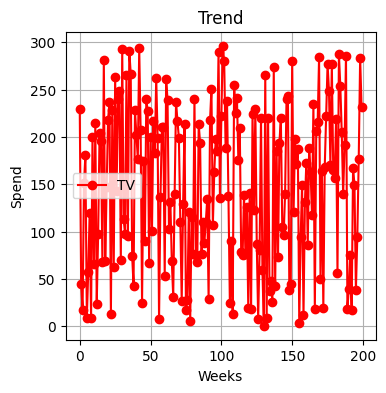

<Figure size 640x480 with 0 Axes>

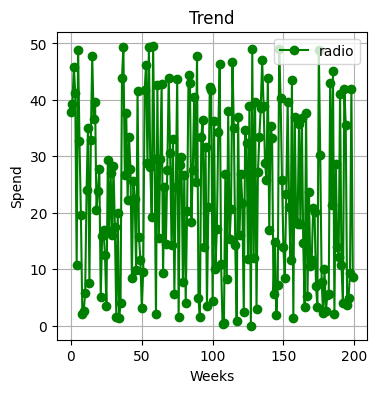

<Figure size 640x480 with 0 Axes>

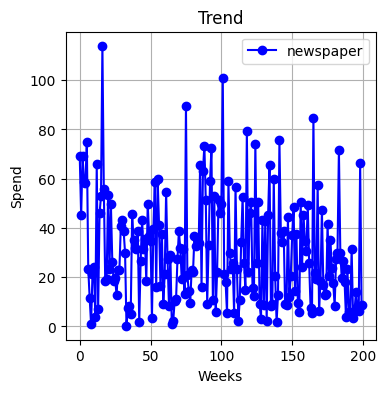

<Figure size 640x480 with 0 Axes>

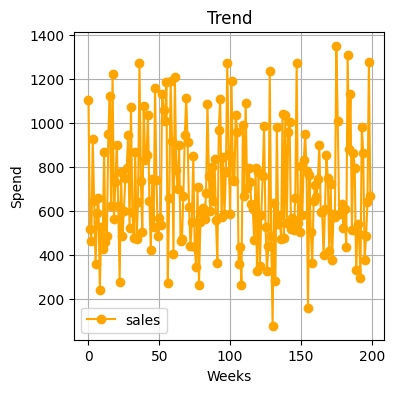

<Figure size 640x480 with 0 Axes>

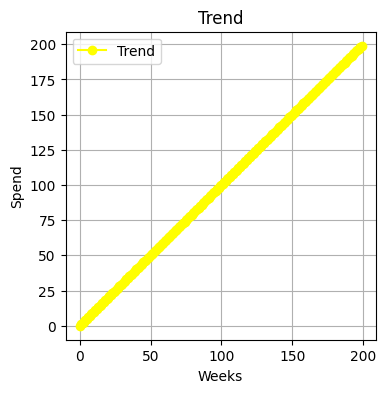

<Figure size 640x480 with 0 Axes>

In [ ]:

colors = ['red', 'green', 'blue', 'orange', 'yellow']
for i in range(len(data.columns)):
  plt.figure(figsize=(4, 4))
  plt.plot(data[data.columns[i]], marker='o', label=data.columns[i], color=colors[i])
  plt.xlabel('Weeks')
  plt.ylabel('Spend')
  plt.title('Trend')
  plt.legend()
  plt.grid(True)
  plt.show()
  plt.clf()



*   Heatmap help us understand correlation of the different channel metrics
*   It is completely normal that there is a high corr since multiple teams can increase or decrease their channel spends simultaneously




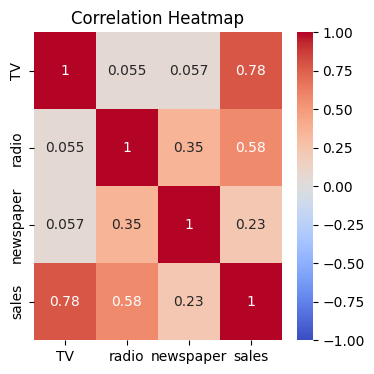

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(data[['TV', 'radio', 'newspaper', 'sales']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()



*   You need to also pass in the Time as one of the columns which is used by model to predict seasonlity
*   MMM model uses fourier series which is a mix of sine and cosine to predict seasonlity
*   You can pass on Yearly seasonlity with default number of seasons as 4-5





In [ ]:
from datetime import datetime, timedelta

In [ ]:
start_date = datetime(2024, 1, 1)
data["w"] = [start_date + timedelta(weeks= i) for i in range(len(data["Trend"]))]
data.head(n = 4)

,TV,radio,newspaper,sales,Trend,w
0,230.1,37.8,69.2,1105.0,0,2024-01-01
1,44.5,39.3,45.1,520.0,1,2024-01-08
2,17.2,45.9,69.3,465.0,2,2024-01-15
3,151.5,41.3,58.5,925.0,3,2024-01-22


***The data fed to model is NOT standardised so that the different features can be learnt with scales for the analysis***

The input data consists of:
1. control columns - Which have a direct impact on final output. Control output are multiplied with coefficients known as gama to calculate their actual output
2. channel columns - Channel columns are transformed using adstock and saturation and also multipled by gama to understand their actual aoutput
3. Output - Sales
4. Date columns - Date could be in weekly or daily

The contole columns consist of
1. Trend
2. Any external output of environment - such as festivals, covid etc. It can be representes as a 0/1
3. Impact due to competitors - again can be represented as zero or 1
4. Trend can be added here and the model has inherent capability of calculating Trend using normal distribution

Similar to other models, the data is split in test and control, to see if the predicited coefficients matches te output


In [ ]:
# set date column
date_col = "w"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["TV",
                "radio",
                "newspaper"]

# set control variables
control_cols = ["Trend"]


# split data into features and target
X = data[[date_col] + channel_cols + control_cols]
y = data[y_col]
print(X, y)

             w     TV  radio  newspaper  Trend
0   2024-01-01  230.1   37.8       69.2      0
1   2024-01-08   44.5   39.3       45.1      1
2   2024-01-15   17.2   45.9       69.3      2
3   2024-01-22  151.5   41.3       58.5      3
4   2024-01-29  180.8   10.8       58.4      4
..         ...    ...    ...        ...    ...
195 2027-09-27   38.2    3.7       13.8    195
196 2027-10-04   94.2    4.9        8.1    196
197 2027-10-11  177.0    9.3        6.4    197
198 2027-10-18  283.6   42.0       66.2    198
199 2027-10-25  232.1    8.6        8.7    199

[200 rows x 5 columns] 0      1105.0
1       520.0
2       465.0
3       925.0
4       645.0
        ...  
195     380.0
196     485.0
197     640.0
198    1275.0
199     670.0
Name: sales, Length: 200, dtype: float64


In [ ]:
# create train and test indices

test_len = 8
train_idx = slice(0, len(data) - test_len)
out_of_time_idx = slice(len(data) - test_len, len(data))

In [ ]:
train_idx

slice(0, 192, None)

Creating a dummy model to show default priors

**Definition of coefficents**
1. intercept - The baseline level of sales or target variable in the absence of
any marketing spend or other variables. It sets the starting point for the model.
2. likelihood - When you increase the focus on the likelihood, the model relies more heavily on the observed data and less on the priors. This means the model will be more data-driven, allowing the observed outcomes to have a stronger influence on the parameter estimates
3. gamma control - Control variables that account for external factors, such as macroeconomic conditions, holidays, or other non-marketing variables that might influence sales.
4. gamma fourier - Fourier terms used to model seasonality in the data, capturing recurring patterns or cycles in sales.
5. adstock alpha - Controls the adstock effect, determining how much the impact of marketing spend decays over time.
saturation lamda - Defines the steepness of the saturation curve, determining how quickly diminishing returns set in as marketing spend increases.
6. saturation beta - The marketing spend coefficient, which measures the direct effect of marketing spend on the target variable (e.g. sales).

**Why some specific deafaults are chosen for coefficients**
1. Normal: For parameters where we expect values to cluster around a mean.Since trend and external factor can be both positive or negative, Normal destribution is used for this sceanrio

2. Half-Normal: For parameters where we want to enforce positivity.

3. **Adstock** - Adstock reflects the idea that the influence of a marketing activity is delayed and builds up over time. The **adstock alpha (the decay rate)** controls how quickly the effect diminishes over time, determining how long the impact of the marketing activity continues to influence sales. A beta distribution is used as a prior for adstock alpha. We typically constrain adstock alpha values between 0 and 1, making the beta distribution a sensible choice. Specifically, using a beta(1, 3) prior for adstock alpha reflects the belief that, in most cases, the decay rate should be relatively high, meaning the effect of marketing activities wears off quickly.

4. **Saturation lamda** - As we increase marketing spend, it’s incremental impact of sales slowly starts to reduce – This is known as saturation. Saturation lamda controls the steepness of the saturation curve, determining how quickly diminishing returns set in.
A gamma distribution is used as a prior for saturation lambda.

5. **Saturation beta** - Saturation beta corresponds to the marketing channel coefficient, measuring the impact of marketing spend. The half-normal prior is used as it enforces positivity which is a very reasonable assumption e.g. marketing shouldn’t have a negative effect in any scenario

6. Beta: For parameters which are constrained between 0 and 1.

7. Gamma: For parameters that are positive and skewed.




In [ ]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock= GeometricAdstock(l_max=4),
    saturation= LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

1. This could be used to see all the arguments avaialble in MMM.

In [ ]:
import inspect
print(inspect.signature(MMM.__init__))
temp = str(inspect.signature(MMM.__init__))
temp = temp.replace("(", '').replace(")", "")
for i in temp.split(","):
  print(i, "\n")

(self, date_column: str = FieldInfo(annotation=NoneType, required=True, description='Column name of the date variable.'), channel_columns: list[str] = FieldInfo(annotation=NoneType, required=True, description='Column names of the media channel variables.', metadata=[MinLen(min_length=1)]), adstock: Annotated[pymc_marketing.mmm.components.adstock.AdstockTransformation, InstanceOf()] = FieldInfo(annotation=NoneType, required=True, description='Type of adstock transformation to apply.'), saturation: Annotated[pymc_marketing.mmm.components.saturation.SaturationTransformation, InstanceOf()] = FieldInfo(annotation=NoneType, required=True, description='Type of saturation transformation to apply.'), time_varying_intercept: bool = FieldInfo(annotation=NoneType, required=False, default=False, description='Whether to consider time-varying intercept.'), time_varying_media: bool = FieldInfo(annotation=NoneType, required=False, default=False, description='Whether to consider time-varying media contr



```
mmm = MMM(
    target='sales',
    date_column='week',
    channel_columns=['TV', 'Digital', 'Radio'],
    control_columns=['price', 'promo'],
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    beta_prior=lambda shape: Normal.dist(mu=0, sigma=0.3, shape=shape),
    prior_sigma=HalfNormal.dist(sigma=1),
    adstock_params_prior=lambda n: Beta.dist(alpha=2, beta=2, shape=n),
    saturation_params_prior=lambda n: HalfNormal.dist(sigma=1, shape=n)
    yearly_seasonality=4
)
```

1. Most of the coefficients are default configurations are default in nature
2. The configurations can be added to make a distribution more strict
3. Further, you can provide different priors for different channels in distribution

```
beta_prior=lambda shape: pm.Normal.dist(mu=np.zeros(shape),
                                        sigma=np.array([0.2, 0.5, 0.8]),
                                        shape=shape)
```
4. yearly_seasonality created fouries series for seasonality in the analysis


In [ ]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
    yearly_seasonality=4
)

In [ ]:
fit_kwargs = {
    "tune": 1_000,
    "chains": 4,
    "draws": 1_000,
    "target_accept": 0.9,
}

mmm_default.fit(X[train_idx], y[train_idx], **fit_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


c:\Users\sahil\miniconda3\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

It helps us understand if there were any coefficietns which didnt converge to a mean and thus were not calculated properly under contrains in this sceanrio

In [ ]:
mmm_default.idata["sample_stats"]["diverging"].sum().item()

0

In [ ]:
import arviz as az



$$Y_t = \beta_0 + (\beta_{Trend} \cdot \text{Trend}_t) + (\sum \beta_{Season} \cdot \text{Seasonality}_t) + (\sum \beta_{Media} \cdot \text{Media Transformed}_t) + \epsilon_t$$

1. $$\beta_0$$ - intercept or baseline sales that is there due to demand of a product
2. Baseline sales - $$\beta_0 + (\beta_{Trend} \cdot \text{Trend}_t) + (\sum \beta_{Season} \cdot \text{Seasonality}_t)$$
3. The different will have different channel coefficients
4. y_sigma	- refers to noise in the model and is represented as \epsilon_t$$



In [ ]:
az.summary(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.016,0.023,-0.027,0.059,0.000,0.000,2793.0,2764.0,1.0
y_sigma,0.057,0.003,0.052,0.063,0.000,0.000,4399.0,3138.0,1.0
saturation_beta[TV],0.568,0.028,0.518,0.621,0.001,0.001,3310.0,1961.0,1.0
saturation_beta[radio],1.159,0.572,0.485,2.236,0.012,0.016,3155.0,2471.0,1.0
saturation_beta[newspaper],0.039,0.069,0.000,0.115,0.001,0.005,2763.0,2601.0,1.0
saturation_lam[TV],3.097,0.342,2.481,3.757,0.006,0.006,3121.0,2023.0,1.0
saturation_lam[radio],0.779,0.320,0.232,1.382,0.005,0.004,3156.0,2443.0,1.0
saturation_lam[newspaper],2.342,1.651,0.056,5.393,0.023,0.031,4068.0,2345.0,1.0
adstock_alpha[TV],0.037,0.021,0.000,0.073,0.000,0.000,2389.0,1644.0,1.0
adstock_alpha[radio],0.024,0.020,0.000,0.062,0.000,0.000,3163.0,1537.0,1.0


In [ ]:
results = az.summary(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)
results.loc["adstock_alpha[TV]", "mean",]

np.float64(0.037)

To understand the distribution of different calculated coefficients

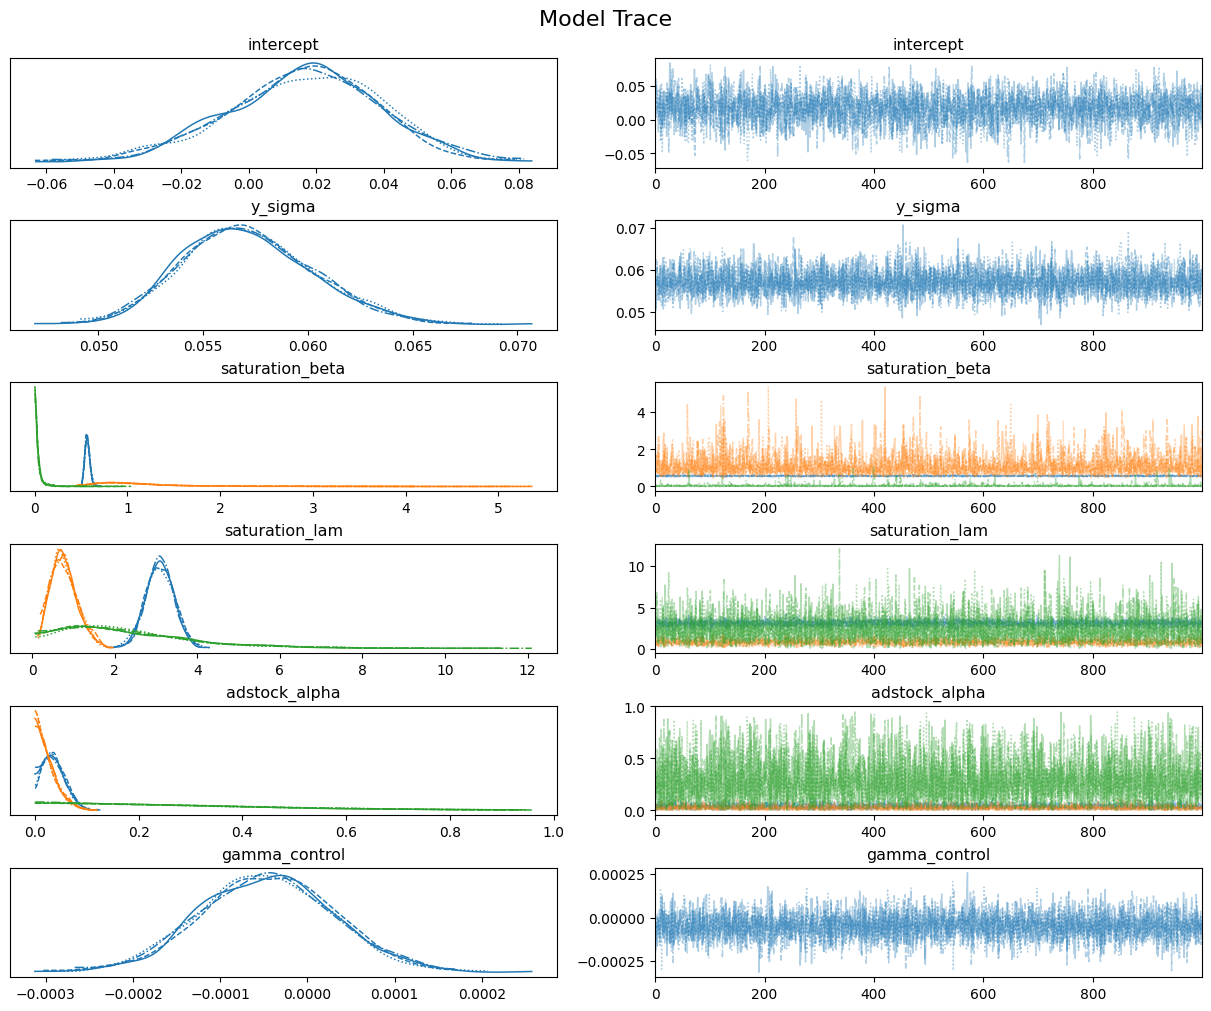

In [ ]:
_ = az.plot_trace(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",

        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [ ]:
mmm_default.sample_posterior_predictive(X[train_idx], extend_idata=True, combined=True)


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (date: 192, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2024-01-01 2024-01-08 ... 2027-08-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 1.127e+03 938.9 985.1 ... 315.6 269.8
Attributes:
    created_at:                 2025-11-15T02:11:34.377903+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1

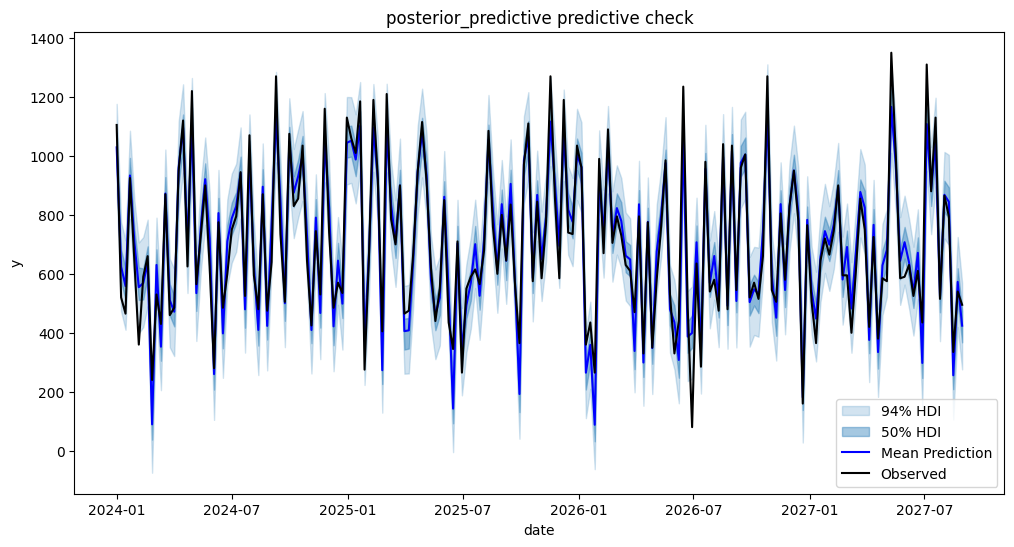

In [ ]:
mmm_default.plot_posterior_predictive(original_scale=True, figsize=(12, 6));


The below graph is for distribution of noise. Noise should have a mean around zero and have a normal distribution as below.

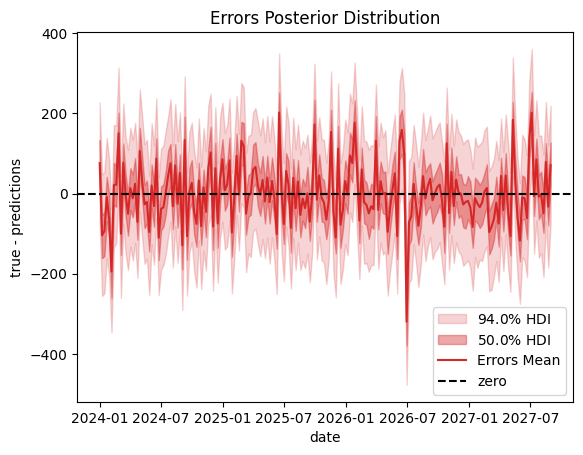

In [ ]:
mmm_default.plot_errors(original_scale=True);


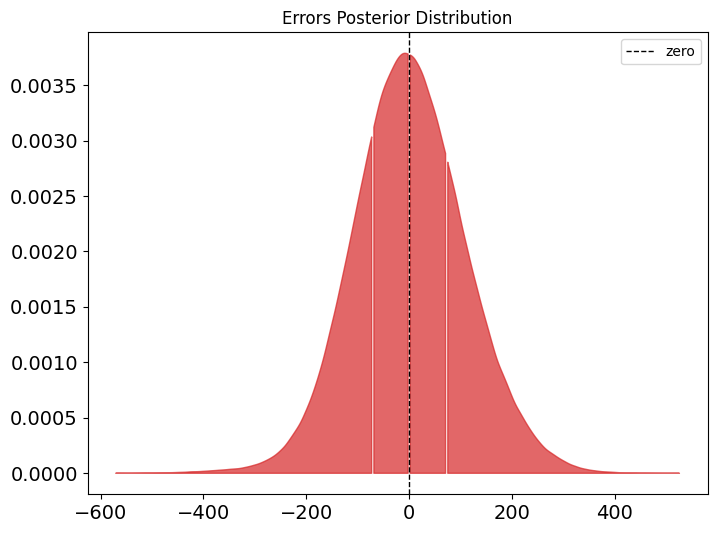

In [ ]:
errors = mmm_default.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

How trained model output is against test values

Output()

/tmp/ipython-input-1855034869.py:20: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_out_of_sample[date_col].dt.to_pydatetime(),


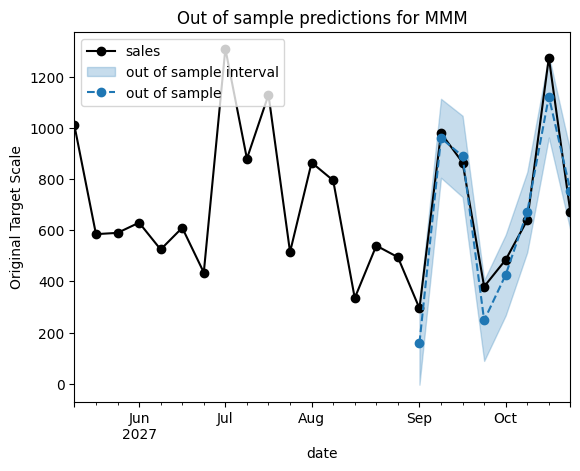

In [ ]:
y_out_of_sample = mmm_default.sample_posterior_predictive(
    X_pred=X[out_of_time_idx], extend_idata=False, include_last_observations=True
)

def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X[date_col])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax

def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample[date_col].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax

_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax, n_points=len(X[out_of_time_idx])*3)
plot_out_of_sample(
    X[out_of_time_idx], y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left");

The adstock coefficients for TV and Radio is very less which states the the impact of marketing channel have a very less carry over
This is against the usual impact of channels
1. TV / Broad-reach broadcast - Typical α: 0.6 – 0.9 (long memory), Suggested prior: Beta(5, 2) → mean ≈ 0.714
2. Radio - Typical α: 0.2 – 0.5, Suggested prior: Beta(2, 3) → mean = 0.4
3. Display / Social (brand-focused) - Typical α: 0.1 – 0.4; Suggested prior: Beta(2, 5) → mean ≈ 0.286
4. Paid Search (search / SEM): Typical α: 0.01 – 0.15, Suggested prior: Beta(1.5, 10) → mean ≈ 0.13
5. Email / Direct (campaigns/promos) - Typical α: 0 – 0.2: Suggested prior: Beta(1, 4) → mean = 0.20 (or Beta(1,6) for mean ≈ 0.14)

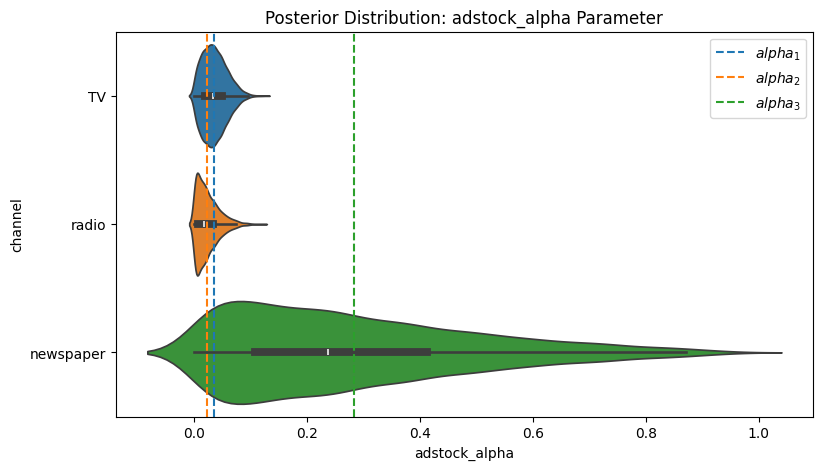

In [ ]:
fig = mmm_default.plot_channel_parameter(param_name="adstock_alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=results.loc["adstock_alpha[TV]", "mean"], color="C0", linestyle="--", label=r"$alpha_1$")
ax.axvline(x=results.loc["adstock_alpha[radio]", "mean"], color="C1", linestyle="--", label=r"$alpha_2$")
ax.axvline(x=results.loc["adstock_alpha[newspaper]", "mean"], color="C2", linestyle="--", label=r"$alpha_3$")
ax.legend(loc="upper right");

Even though the data is fed as is in the model, but the internal algorithm normalise the data to calculate saturation coefficients
Broad-reach channels (TV, Brand Video)

Typical behavior: saturates late — incremental responses continue at higher spends.

**Practical default ranges & priors (for normalized inputs)**
1. Broad-reach channels (TV, Brand Video), Typical behavior: saturates late — incremental responses continue at higher spends.

    β (half-sat): typical range 0.6 – 2.0, Prior: LogNormal(mu=0, sigma=0.6) → median ≈ 1.0 (covers 0.5–2 comfortably)

    λ (steepness): 0.7 – 1.5, Prior: Gamma(2, 1) (mean 2 → you can use Gamma(1.5, 1) or LogNormal(log(1), 0.5) for ~1)

2. Mid-reach / repeated-display (OOH, Display brand, Social brand creatives, Typical behavior: moderate saturation

    β: 0.3 – 1.0, Prior: LogNormal(mu=-0.3, sigma=0.6) → median ≈ 0.74

    λ: 0.6 – 1.2, Prior: Gamma(2, 1) or LogNormal(log(1), 0.7)

3. Lower-latency channels (Radio, Some social direct-response), Typical behavior: saturates earlier than TV

    β: 0.2 – 0.6, Prior: LogNormal(mu=-1, sigma=0.7) → median ≈ 0.37

    λ: 0.5 – 1.0, Prior: Gamma(1.5, 1) or LogNormal(log(0.8), 0.6)

4. High-immediacy / performance channels (Paid Search, Affiliate), Typical behavior: strong immediate effect → quick saturation (low β)

    β: 0.01 – 0.2 (often very small after normalisation), Prior: LogNormal(mu=-2.5, sigma=1.0) → median ≈ 0.08

    λ: 0.3 – 1.0 (often <1 for smooth concave response), Prior: Gamma(1.2, 1) or LogNormal(log(0.6), 0.7)

4. Email / CRM / Promotional blasts, Typical behavior: strong spike + quick tail

    β: 0.05 – 0.3, Prior: LogNormal(mu=-2, sigma=0.8) → median ≈ 0.14

    λ: 0.4 – 1.0, Print / Newspaper / Flyers (if used)

5. Print / Newspaper / Flyers (if used): Typical behavior: often small effect, saturates quickly if at all,

    β: 0.05 – 0.4 (high uncertainty), Prior: LogNormal(mu=-1.5, sigma=1.0)

    λ: 0.4 – 1.0

In [ ]:
fig = mmm_default.plot_channel_parameter(param_name="saturation_lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=saturation_lamdas[0], color="C0", linestyle="--", label=r"$lambda_1$")
ax.axvline(x=saturation_lamdas[1], color="C1", linestyle="--", label=r"$lambda_2$")
ax.axvline(x=saturation_lamdas[2], color="C2", linestyle="--", label=r"$lambda_3$")
ax.legend(loc="upper right");

When you ask Pymc-Marketing to show the final channel contribution share (e.g., using mmm.plot_components_contributions()), it typically does the following:
1. Calculates the Total Incremental Sales (the part of sales above the baseline) for every MCMC sample.
2. Calculates the Total Contribution for each individual channel (summing the $\text{Contribution}_{m, t, i}$ over all time periods $t$) for every MCMC sample.
3. Computes the Contribution Share for each channel for every sample by dividing the channel's total contribution by the total incremental sales.
4. Summarizes the Distribution to present the final result, usually showing the mean (or median) of the contribution share distribution, along with the credible interval (e.g., 95% HDI).

In [ ]:
channel_contrib
posterior_samples = channel_contrib.stack(draws=("chain", "draw")).values

array([[[0.50143808, 0.45594149, 0.43457996, ..., 0.45488873,
         0.48179229, 0.46520336],
        [0.27327645, 0.28209   , 0.27134328, ..., 0.29310222,
         0.25746916, 0.26851744],
        [0.00549794, 0.00796107, 0.013219  , ..., 0.01467333,
         0.01367341, 0.02301296]],

       [[0.14962672, 0.12742522, 0.11844418, ..., 0.13852281,
         0.1604624 , 0.13705948],
        [0.28917091, 0.29351287, 0.28308087, ..., 0.31293202,
         0.26882678, 0.28325265],
        [0.00627094, 0.00670358, 0.01095295, ..., 0.0146424 ,
         0.01144554, 0.02379639]],

       [[0.05684894, 0.04989082, 0.04603442, ..., 0.05180193,
         0.05902091, 0.05114425],
        [0.32904384, 0.34052924, 0.32934047, ..., 0.35719741,
         0.31155536, 0.32557258],
        [0.00825112, 0.00870058, 0.01476757, ..., 0.0197496 ,
         0.01405816, 0.03097185]],

       ...,

       [[0.07365873, 0.05508605, 0.05225362, ..., 0.0729443 ,
         0.09401569, 0.07197883],
        [0.09556074, 